In [11]:
import numpy as np
import matplotlib.pyplot as plt

In [12]:
%matplotlib inline

## Three rooms grid

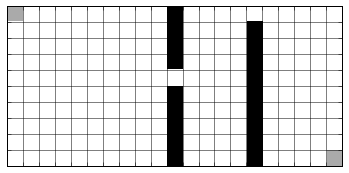

In [32]:
grid = np.zeros((10,21))
grid[:,10] = -3
grid[4,10] =  0
grid[:,15] = -3
grid[0,15] =  0

START= (0,0)
GOAL = (9,20)
WESTregion_LIMIT = 10 #not included 

grid[START] = -1
grid[GOAL]  = -1
plt.imshow(grid, cmap='gray', interpolation='nearest', extent = [0,21,0,10])
ax = plt.gca();
ax.set_xticks(np.arange(0,21, 1));
ax.set_yticks(np.arange(0, 10, 1));
ax.set_xticklabels([]);
ax.set_yticklabels([]);
plt.grid(color='black', which = 'major', linestyle='-')
plt.savefig('3rooms.png', bbox_inches='tight')
plt.show()

grid[START] = 0
grid[GOAL]  = 0

In [25]:
from collections import defaultdict
from utils import getTransitions_and_Rewards
from random import shuffle

In [15]:
"""
actions  = [up,down,right,left]
"""
trans, r = getTransitions_and_Rewards(grid, GOAL)
gamma = 0.9
p_uniform = 0.1

## SubGoals discovery

In [16]:
novelty     = lambda s: 1.0/np.sqrt(nbVisits[s])

set_novelty = lambda S: 1.0/np.sqrt(nbVisits[np.array([s[0] for s in S]), np.array([s[1] for s in S])].mean())  

def rel_novelty(prev_sequence, succ_sequence):
    return float(set_novelty(succ_sequence)) / set_novelty(prev_sequence)

In [17]:
def isTarget(state):    
    n1 = sum(scores[state])
    n  = len(scores[state])
    rhs= np.log(float((1-q))/(1-p)) / np.log(float(p*(1-q))/q*(1-p)) + 1.0/n * (np.log(float(costRatio * priorRatio))/ np.log(float(p*(1-q)) / (q*(1-p))))
    if (float(n1)/n > rhs):
        return True
    return False

In [26]:
from IPython.display import clear_output
import sys
from random import shuffle

In [23]:
#with random ties breaking (and not just taking first action, otherwise I go into loop becuase rewards are 0 for non-term)
def greedyAction(state, Q):
    actions = range(4)
    shuffle(actions)
    
    bestAct = -1
    qMax = -np.inf
    
    for a in actions:        
        if Q[state][a] > qMax:
            bestAct = a
            qMax    = Q[state][a]
    
    return bestAct
        

In [29]:
""" Classification parameters"""
t_RN = 2
p = 0.0712
q = 0.0056
costRatio = 100
priorRatio = 100
ln = 7
lo = 10 #nb states to include in the Inititation state


westRegion = [(i,j) for i in range(10) for j in range(WESTregion_LIMIT)]
eps = 0.1
alpha = 0.05
nbEpisodes = 80

nbSubGoal_tot = np.zeros((10,21))

goals_per_run = []

with warnings.catch_warnings():
    warnings.simplefilter('error')
    
    for run in range(30):    
        Q = defaultdict(lambda: [0,0,0,0]) 
        scores = defaultdict(list)
        nbSubGoal = np.zeros((10,21))    

        Options = defaultdict(lambda: [0,0,0,0])
        for episode in range(80): 
            clear_output()  
            print "Run: ",run
            print "Episode:", episode
            sys.stdout.flush()
            #RESET visit counts periodically
            nbVisits = np.zeros((10,21))        
            states_visited = []        

            state = START

            states_visited.append(state)
            nbVisits[state] +=1  #should I count as visit also the starting visit?

            while (state != GOAL):

                #choose A from S
                if np.random.binomial(1,eps):
                    a = np.random.choice(range(len(Q[state])))
                else:
                    a = greedyAction(state, Q)            



                #take A and observe S'        
                if (np.random.binomial(1, p_uniform)):
                    nextState = trans[state][np.random.choice(range(4))]
                else:
                    nextState = trans[state][a]

                #and R
                R = r[nextState]

                #greedy action from S'
                next_greedy_a = greedyAction(nextState, Q)

                Q[state][a]  += alpha * (R + gamma * Q[nextState][next_greedy_a] - Q[state][a])             

                """
                keep track of states visited to compute relative novelty scores
                """
                if nextState != state:
                    states_visited.append(nextState)                
                    nbVisits[nextState]+=1

                "Update novelty score of states visited nlag steps before and checkTarget"
                if len(states_visited) >= (2*ln):

                    prec_seq = states_visited[-2*ln:-ln]
                    succ_seq = states_visited[-ln:]                   
                    score = rel_novelty(prec_seq, succ_seq)

                    state2update = states_visited[-ln]

                    if score >= t_RN:
                        score =1
                    else:
                        score =0
                    scores[state2update].append(score)

                    if isTarget(state2update):
                        nbSubGoal[state2update] +=1
                        nbSubGoal_tot[state2update] += 1   

                state = nextState           

        goals_per_run.append((nbSubGoal>0).sum())

Run:  29
Episode: 79


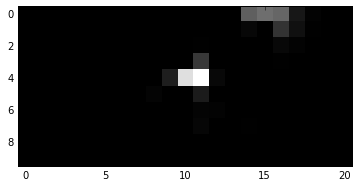

In [31]:
plt.imshow(nbSubGoal_tot, cmap='gray', interpolation='nearest')
plt.savefig('sub3rooms.png', bbox_inches= 'tight')
plt.show()